# IMPORTS

In [1]:
import sys
sys.path.insert(0, "../..")
import config as cfg
import gc
import os
from typing import Optional, Any, Union, Callable

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from metrics import compute_single_col_score, get_tresholds, compute_weird_pred_proba_score, compute_weird_pred_score
from sklearn.metrics import recall_score
from helper import make_prediction, check_path, get_prediction, evaluate, seed_everything, save_submission, save_pred_proba_oof, save_pred_proba_test
from collections import defaultdict
import category_encoders as ce

In [60]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold, train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [4]:
import catboost as cb
import catboost.datasets as cbd
import catboost.utils as cbu

In [5]:
RANDOM_STATE = 77
seed_everything(RANDOM_STATE)

# MODEL TRAINING

In [6]:
train = pd.read_pickle(cfg.PREPARED_TRAIN_DATA_PATH)
test = pd.read_pickle(cfg.PREPARED_TEST_DATA_PATH)

In [7]:
X_train, Y_train = train.drop(cfg.TARGETS, axis=1), train[cfg.TARGETS]

In [41]:
udf = pd.concat([X_train, test])
is_test = pd.DataFrame([0] * len(X_train) + [1] * len(test), index=udf.index, columns=['is_test'])

In [47]:
idx = np.arange(len(udf))
np.random.shuffle(idx)

In [51]:
clf = cb.CatBoostClassifier(cat_features=cfg.CAT_UNORDERED_COLS)
clf.fit(udf.iloc[idx], is_test.iloc[idx], silent=True)

In [52]:
is_test_pred = clf.predict_proba(udf)

<AxesSubplot:ylabel='Count'>

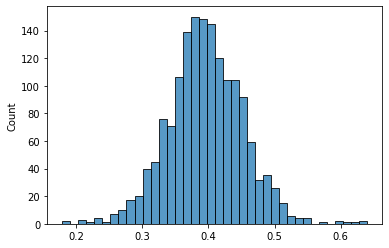

In [63]:
sns.histplot(is_test_pred[:, 1])

In [66]:
is_test_pred = pd.DataFrame(is_test_pred[:, 1], index=is_test.index, columns=['is_test'])

In [72]:
((is_test_pred < 0.3) | (is_test_pred > 0.5)).values

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [73]:
outliers = is_test_pred.loc[((is_test_pred < 0.3) | (is_test_pred > 0.5)).values]

In [75]:
outliers.shape

(113, 1)

In [78]:
len(is_test_pred)

1593

In [79]:
len(is_test_pred.drop(outliers.index))

1480

In [53]:
roc_auc_score(is_test, is_test_pred[:, 1])

0.7386991416238572

In [80]:
roc_auc_score(is_test.drop(outliers.index), is_test_pred.drop(outliers.index))

0.7154951320459857

In [54]:
fi = pd.Series(data=clf.feature_importances_, index=clf.feature_names_)

In [92]:
pd.concat([
        train[['sleep_time']].assign(hue='train'), 
        test[['sleep_time']].assign(hue='test')])

,sleep_time,hue
id,,
54-102-358-02,22:00:00,train
54-103-101-01,00:00:00,train
54-501-026-03,23:00:00,train
54-501-094-02,23:00:00,train
54-503-022-01,23:00:00,train
...,...,...
54-102-095-01,23:00:00,test
54-102-235-01,01:00:00,test
54-502-016-01,22:00:00,test


<AxesSubplot:xlabel='sleep_time', ylabel='Probability'>

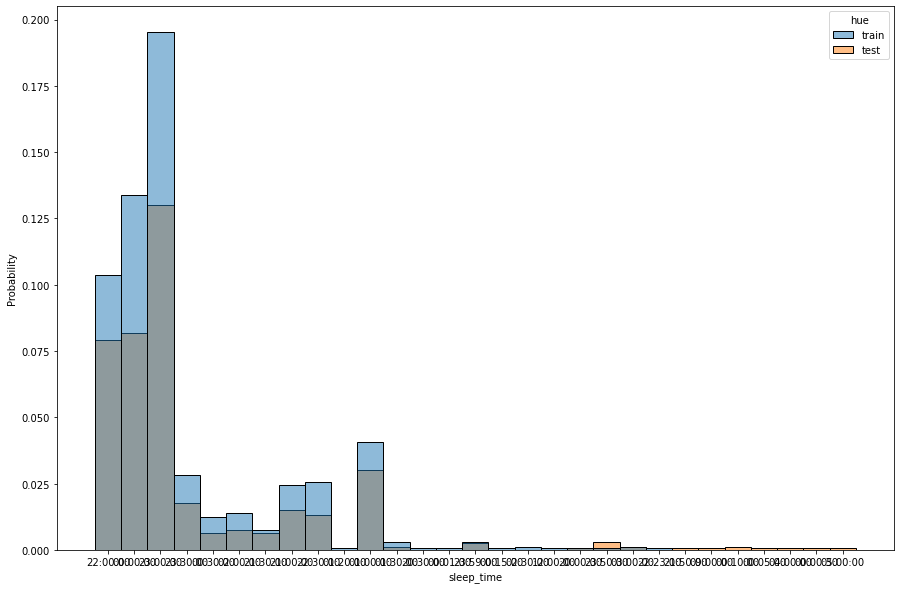

In [100]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(
    pd.concat([
        train[['sleep_time']].assign(hue='train'), 
        test[['sleep_time']].assign(hue='test')]),
        x='sleep_time',
        hue='hue',
        bins=100,
        stat='probability',
        ax=ax)

<AxesSubplot:>

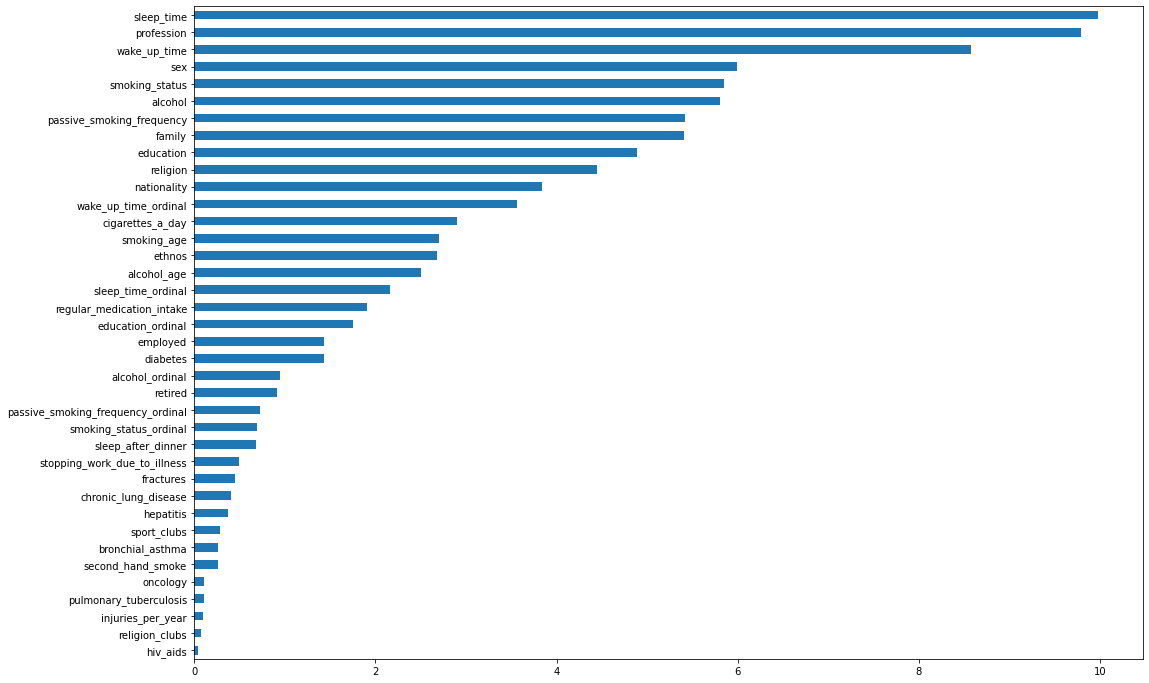

In [58]:
fi.sort_values().plot(kind='barh', figsize=(17,12))

In [ ]:
EXCLUDE_COLS = ['sleep_time']

In [ ]:
X_train.drop(EXCLUDE_COLS, axis=1, inplace=True)
test.drop(EXCLUDE_COLS, axis=1, inplace=True)

In [8]:
EXPERIMENT_FAMILY_NAME = 'catboost'
EXPERIMENT_NAME = 'extcv'
N_SPLITS = 7

In [9]:
CAT_COLS = cfg.CAT_UNORDERED_COLS

In [10]:
def get_cat_pool(data: pd.DataFrame, labels: Optional[pd.DataFrame]=None, shuffle: bool=True, batch_size: int=32):
  return cb.Pool(
    data=data, 
    label=labels,
    cat_features=CAT_COLS)

In [11]:
def get_cat_model(train, iterations: int = None):
    return cb.CatBoostClassifier(
            loss_function='MultiLogloss',
            # custom_metric=['Recall', 'F1'],
            # eval_metric='F:beta=2',
            # grow_policy='Lossguide',
            iterations=3000 if iterations is None else iterations,
            early_stopping_rounds=100 if iterations is None else None,
            silent=True,
            depth=4,
            l2_leaf_reg=2.0,
            learning_rate=0.001,
            random_seed=RANDOM_STATE
        )

In [12]:
def fit_cat_model(train, val=None, iterations: int = None):
    model = get_cat_model(train, iterations)
    model.fit(train, eval_set=val, plot=False)
    best_iter = model.get_best_iteration()
    return model, best_iter

In [13]:
def save_cat_model(model: Any, experiment_name: str, experiment_family_name: str, fold: int, suffix='') -> None:
    if suffix:
        suffix = '_' + suffix

    model_name = f'{experiment_name}_fold_{fold}_rs_{RANDOM_STATE}{suffix}.cbm'
    model_path = os.path.join(cfg.MODELS_PATH, experiment_family_name, experiment_name)
    check_path(model_path)
    model.save_model(os.path.join(model_path, model_name))

In [14]:
def predict_with_cat_model(model, data) -> np.ndarray:
    return model.predict_proba(data)

In [15]:
def apply_cat_encoding(cat_encoders: dict, X_train, Y_train, X_val) -> tuple[pd.DataFrame, pd.DataFrame]:
    def _rename_cols(df: pd.DataFrame, target_col: str, encoder_name: str) -> pd.DataFrame:
        df.columns = [f'{cat_col}_{target_col}_{encoder_name}' for cat_col in df.columns]
        return df

    X_cat_train, X_cat_val = [], []
    for encoder_name, encoder in cat_encoders.items():
        for target_col in Y_train.columns:
            X_cat_train_enc = encoder.fit_transform(X_train, Y_train[target_col])
            X_cat_train_enc = _rename_cols(X_cat_train_enc, target_col, encoder_name)
            X_cat_train.append(X_cat_train_enc)

            X_cat_val_enc = encoder.transform(X_val)
            X_cat_val_enc = _rename_cols(X_cat_val_enc, target_col, encoder_name)
            X_cat_val.append(X_cat_val_enc)
    return pd.concat([X_train] + X_cat_train, axis=1), pd.concat([X_val] + X_cat_val, axis=1)

In [16]:
cat_encoders = {
    'WOE': ce.WOEEncoder(cols=CAT_COLS, random_state=RANDOM_STATE),
    # 'TE': ce.TargetEncoder(cols=CAT_COLS)
}

In [17]:
weird_scores = []

cv = MultilabelStratifiedKFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle=True)

pred_int_whole = pd.DataFrame(index=Y_train.index, columns=Y_train.columns, dtype=np.int32)
pred_proba_oof_whole = pd.DataFrame(index=Y_train.index, columns=Y_train.columns, dtype=np.float32)
best_iters_global = []
for train_idx, val_idx in tqdm(cv.split(X_train, Y_train), total=N_SPLITS):

    pred_template = Y_train.iloc[val_idx].copy()
    pred_template.iloc[:, :] = 0

    train_data, test_data = apply_cat_encoding(
        cat_encoders=cat_encoders,
        X_train=X_train.iloc[train_idx],
        Y_train=Y_train.iloc[train_idx],
        X_val=X_train.iloc[val_idx]
    )
    
    
    prediction, pred_proba_oof, pred_proba_test, best_iters = get_prediction(
        train_data=train_data,
        train_labels=Y_train.iloc[train_idx],
        test_data=test_data,
        pred_template=pred_template,
        process_input=get_cat_pool,
        save_model=save_cat_model,
        fit_model=fit_cat_model,
        predict=predict_with_cat_model,
        n_splits=3,
        random_state=RANDOM_STATE,
        experiment_name=EXPERIMENT_NAME,
        experiment_family_name=EXPERIMENT_FAMILY_NAME,
        suffix='eval',
        rename_cols=False,
        )
    
    pred_int_whole.iloc[val_idx] = prediction
    pred_proba_oof_whole.iloc[val_idx] = pred_proba_test
    best_iters_global.extend(best_iters)

metrics = evaluate(
    test_labels=Y_train,
    prediction=pred_int_whole.astype(np.int32), 
    pred_proba_test=pred_proba_oof_whole
    )


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[0.6913938229056203, 0.6860167130919219, 0.6104875036326649, 0.6994891443167306, 0.7266979682021231]
0.6828170304298122 0.03877848853745161


  0%|          | 0/3 [00:00<?, ?it/s]

[0.6965934389732844, 0.7001434126699578, 0.635824415019046, 0.7008928571428571, 0.7258006563345869]
0.6918509560279464 0.029881657938444425


  0%|          | 0/3 [00:00<?, ?it/s]

[0.6882530120481928, 0.7265785813630041, 0.584454924723381, 0.6855867346938775, 0.7273516659879752]
0.6824449837632861 0.052172866525877756


  0%|          | 0/3 [00:00<?, ?it/s]

[0.6609689909653507, 0.6700139082058415, 0.5829171104337287, 0.6598214285714286, 0.7246067308037907]
0.6596656337960279 0.04520285768410822


  0%|          | 0/3 [00:00<?, ?it/s]

[0.702114262990456, 0.6901392757660167, 0.6120437620667464, 0.6575807334428024, 0.7287033479033576]
0.6781162764338757 0.040166636285110226


  0%|          | 0/3 [00:00<?, ?it/s]

[0.7145315550848861, 0.6953198887343532, 0.6203065481588972, 0.6826530612244899, 0.7202307498771969]
0.6866083606159646 0.03577047749054758


  0%|          | 0/3 [00:00<?, ?it/s]

[0.6851471367974549, 0.690390377949929, 0.5902535600116245, 0.7004475703324808, 0.7354339785772612]
0.6803345247337502 0.04833083082497075
[0.6673821303841676, 0.6597872427228035, 0.5768057376829823, 0.6688504029460426, 0.7230016650955448]
0.6591654357663081 0.046946529897231644
TEST METRICS
defaultdict(<class 'list'>, {'weird_score': 0.6591654357663081, 'oof_auc': 0.6963280143190298, 'oof_logloss': 1.0334590427538488})


In [18]:
print('OVERALL METRICS')
print(metrics)
print(best_iters_global)

OVERALL METRICS
defaultdict(<class 'list'>, {'weird_score': 0.6591654357663081, 'oof_auc': 0.6963280143190298, 'oof_logloss': 1.0334590427538488})
[2999, 2990, 2999, 2999, 2999, 2999, 2998, 2999, 2999, 2995, 2733, 2998, 2999, 2999, 2999, 2999, 2999, 2999, 2998, 2999, 2999]


In [19]:
# defaultdict(<class 'list'>, {'weird_score': 0.6591654357663081, 'oof_auc': 0.6963280143190298, 'oof_logloss': 1.0334590427538488})
# [2999, 2990, 2999, 2999, 2999, 2999, 2998, 2999, 2999, 2995, 2733, 2998, 2999, 2999, 2999, 2999, 2999, 2999, 2998, 2999, 2999]

In [20]:
N_ITERS = int(np.mean(best_iters_global))

In [21]:
# [0.632011421731218, 0.6490860706862861, 0.661385903220677, 0.6271449441761077, 0.6818099910552275]
# 0.6502876661739032 0.01993929966464236

In [22]:
from functools import partial


sample_submission = pd.read_csv(cfg.SAMPLE_SUBMISSION_PATH).set_index('ID')

train_data, test_data = apply_cat_encoding(
        cat_encoders=cat_encoders,
        X_train=X_train,
        Y_train=Y_train,
        X_val=test
    )

prediction_folds, pred_proba_oof_folds, pred_proba_test_folds, _ = get_prediction(
    train_data=train_data,
    train_labels=Y_train,
    test_data=test_data,
    pred_template=sample_submission,
    process_input=get_cat_pool,
    save_model=save_cat_model,
    fit_model=partial(fit_cat_model, iterations=N_ITERS),
    predict=predict_with_cat_model,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE,
    experiment_name=EXPERIMENT_NAME,
    experiment_family_name=EXPERIMENT_FAMILY_NAME,
    suffix=''
    )

  0%|          | 0/7 [00:00<?, ?it/s]

[0.696734332557237, 0.6990545254268405, 0.6014531538523296, 0.6856487164434008, 0.7287237791501846]
0.6823229014859985 0.04287576275867233


In [23]:
# [0.696734332557237, 0.6990545254268405, 0.6014531538523296, 0.6856487164434008, 0.7287237791501846]
# 0.6823229014859985 0.04287576275867233

In [33]:
train_pool_whole = get_cat_pool(train_data, Y_train)
test_pool_whole = get_cat_pool(test_data)
train_model_whole, best_iters = fit_cat_model(train_pool_whole, iterations=N_ITERS)
save_cat_model(train_model_whole, EXPERIMENT_NAME, EXPERIMENT_FAMILY_NAME, -1, 'whole_train')

pred_proba_test_whole = train_model_whole.predict_proba(test_pool_whole)
pred_proba_test_whole = pd.DataFrame(data=pred_proba_test_whole, index=test.index, columns=cfg.TARGETS)

tresholds_whole = get_tresholds(Y_train, pred_proba_oof_whole)
sample_submission = pd.read_csv(cfg.SAMPLE_SUBMISSION_PATH).set_index('ID')
prediction_whole = make_prediction(pred_proba_test_whole, tresholds_whole, sample_submission)

[0.6902405898331394, 0.6975705281194542, 0.6012725131800787, 0.6814991727597801, 0.7278802188411287]
0.6796926045467162 0.04220402998511531


In [34]:
# [0.6902405898331394, 0.6975705281194542, 0.6012725131800787, 0.6814991727597801, 0.7278802188411287]
# 0.6796926045467162 0.04220402998511531

In [35]:
pred_proba_oof_avg = (pred_proba_oof_whole + pred_proba_oof_folds) / 2
pred_proba_test_avg = (pred_proba_test_whole + pred_proba_test_folds) / 2

In [36]:
tresholds_avg = get_tresholds(Y_train, pred_proba_oof_avg)
sample_submission = pd.read_csv(cfg.SAMPLE_SUBMISSION_PATH).set_index('ID')
prediction_avg = make_prediction(pred_proba_test_avg, tresholds_avg, sample_submission)

[0.6908226620100892, 0.6962803174020358, 0.6026039018385206, 0.6838474675775204, 0.7290012950743125]
0.6805111287804957 0.0419212557562048


In [28]:
# [0.6908226620100892, 0.6962803174020358, 0.6026039018385206, 0.6838474675775204, 0.7290012950743125]
# 0.6805111287804957 0.0419212557562048

In [29]:
save_submission(prediction_avg, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, 'avg')
save_pred_proba_oof(pred_proba_oof_avg, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, 'avg')
save_pred_proba_test(pred_proba_test_avg, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, 'avg')

In [30]:
save_submission(prediction_whole, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, 'whole')
save_pred_proba_oof(pred_proba_oof_whole, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, 'whole')
save_pred_proba_test(pred_proba_test_whole, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, 'whole')

In [31]:
save_submission(prediction_folds, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, 'folds')
save_pred_proba_oof(pred_proba_oof_folds, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, 'folds')
save_pred_proba_test(pred_proba_test_folds, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, 'folds')